In [446]:
import numpy as np
import mdtraj as mdt
import MDAnalysis as mda
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import seaborn as sns

In [788]:
def get_nearby_residues(holo_xtal, ligand_resn, dist_cutoff):

    #handle bricks
    if ligand_resn == "None":
        print("no valid ligands found")
        return []

    #handle everything else
    if type(ligand_resn) == str: #select single ligands
        ligand_select_str = f"resname '{ligand_resn}'"

    elif len(ligand_resn)>1:     #select multiple ligands
        #assemble query for all ligands listed
        molecule_queries = []
        for lname in ligand_resn:
            molecule_queries.append(f"resname '{lname}'")
        ligand_select_str = " or ".join(molecule_queries)

    else:                        #use hardcoded query
        ligand_select_str = ligand_resn[0]

    #get indices of ligand and protein atoms
    ligand_ai = holo_xtal.top.select(f"({ligand_select_str}) and not element H")
    protein_ai = holo_xtal.top.select("protein and not element H")

    #get indices of ligand-coordinating protein atoms; index 0 indicates the 0th trajectory frame
    lining_ai = mdt.compute_neighbors(holo_xtal, dist_cutoff, ligand_ai, haystack_indices=protein_ai, periodic = False)[0]

    #get residue indices and numbers for the holo structure
    lining_resids = np.unique([holo_xtal.top.atom(i).residue.index for i in lining_ai])    #0-indices of the lining residues in the mdtraj structure
    lining_resseqs = np.unique([holo_xtal.top.atom(i).residue.resSeq for i in lining_ai])  #rcsb pdb residue numbers of the lining residues
    
    #print([f"resid {i}" for i in lining_resids])
    lining_ai_resi = np.unique(holo_xtal.top.select(" or ".join([f"resid {i}" for i in lining_resids])))
    
    lining_ai_byresi = [holo_xtal.top.select(f"resid {i}") for i in lining_resids]
    lining_names_byresi = [str(holo_xtal.top.atom(holo_xtal.top.select(f"resid {i}")[0]).residue) for i in lining_resids]

    return [lining_ai, lining_resids, lining_resseqs, lining_ai_resi, lining_ai_byresi, lining_names_byresi]

In [664]:
# filepaths
toppath = "/Users/yishengzheng/Documents/UCSF/class/bp219/2022-09_MD-analysis/topo"
trjpath = "/Users/yishengzheng/Documents/UCSF/class/bp219/2022-09_MD-analysis/traj"

# topology files
inb_id = [12346146,12346145, 12346144, 12330880, 12330576, 11738466, 11738465, 11738463, 11738401, 11730068, 11730063, 11730054]
ptopapo = f"{toppath}/11441075.pdb"
ptopholo_inb_list = [f"{toppath}/" + str(i) + ".pdb" for i in inb_id]

# trajectory files
ptrjapo  = [f"{trjpath}/sarscov2-11441075-no-water-zinc-glueCA/sarscov2-11441075-no-water-zinc-glueCA-00" + str("%.2d" % i ) + ".dcd" for i in range(100)]
ptrjholo_inb1 = [f"{trjpath}/sarscov2-12346146-no-water-no-ion-align-CA/sarscov2-12346146-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(2)]
ptrjholo_inb2 = [f"{trjpath}/sarscov2-12346145-no-water-no-ion-align-CA/sarscov2-12346145-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(2)]
ptrjholo_inb3 = [f"{trjpath}/sarscov2-12346144-no-water-no-ion-align-CA/sarscov2-12346144-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(2)]
ptrjholo_inb4 = [f"{trjpath}/sarscov2-12330880-no-water-no-ion-align-CA/sarscov2-12330880-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(2)]
ptrjholo_inb5 = [f"{trjpath}/sarscov2-12330576-no-water-no-ion-align-CA/sarscov2-12330576-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(2)]
ptrjholo_inb6 = [f"{trjpath}/sarscov2-11738466-no-water-no-ion-align-CA/sarscov2-11738466-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(5)]
ptrjholo_inb7 = [f"{trjpath}/sarscov2-11738465-no-water-no-ion-align-CA/sarscov2-11738465-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(5)]
ptrjholo_inb8 = [f"{trjpath}/sarscov2-11738463-no-water-no-ion-align-CA/sarscov2-11738463-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(5)]
ptrjholo_inb9 = [f"{trjpath}/sarscov2-11738401-no-water-no-ion-align-CA/sarscov2-11738401-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(5)]
ptrjholo_inb10 = [f"{trjpath}/sarscov2-11730068-no-water-no-ion-align-CA/sarscov2-11730068-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(5)]
ptrjholo_inb11 = [f"{trjpath}/sarscov2-11730063-no-water-no-ion-align-CA/sarscov2-11730063-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(5)]
ptrjholo_inb12 = [f"{trjpath}/sarscov2-11730054-no-water-no-ion-align-CA/sarscov2-11730054-no-water-no-ion-align-CA-000" + str(i) + ".dcd" for i in range(5)]

In [665]:
# load trajectories

inb1 = [mdt.load_dcd(ptrjholo_inb1[i], top = ptopholo_inb_list[0]) for i in range(2)]
inb2 = [mdt.load_dcd(ptrjholo_inb2[i], top = ptopholo_inb_list[1]) for i in range(2)]
inb3 = [mdt.load_dcd(ptrjholo_inb3[i], top = ptopholo_inb_list[2]) for i in range(2)]
inb4 = [mdt.load_dcd(ptrjholo_inb4[i], top = ptopholo_inb_list[3]) for i in range(2)]
inb5 = [mdt.load_dcd(ptrjholo_inb5[i], top = ptopholo_inb_list[4]) for i in range(2)]
inb6 = [mdt.load_dcd(ptrjholo_inb6[i], top = ptopholo_inb_list[5]) for i in range(5)]
inb7 = [mdt.load_dcd(ptrjholo_inb7[i], top = ptopholo_inb_list[6]) for i in range(5)]
inb8 = [mdt.load_dcd(ptrjholo_inb8[i], top = ptopholo_inb_list[7]) for i in range(5)]
inb9 = [mdt.load_dcd(ptrjholo_inb9[i], top = ptopholo_inb_list[8]) for i in range(5)]
inb10 = [mdt.load_dcd(ptrjholo_inb10[i], top = ptopholo_inb_list[9]) for i in range(5)]
inb11 = [mdt.load_dcd(ptrjholo_inb11[i], top = ptopholo_inb_list[10]) for i in range(5)]
inb12 = [mdt.load_dcd(ptrjholo_inb12[i], top = ptopholo_inb_list[11]) for i in range(5)]
inb_trjlists = [inb1, inb2, inb3, inb4, inb5, inb6, inb7, inb7, inb8, inb9, inb10, inb11, inb12]
apo_inb = [mdt.load_dcd(ptrjapo[i], top = ptopapo) for i in range (5)]

# join trajectories

inb_trjs = []
for i in range(0, 12):
    inb_trjs.append(mdt.join(inb_trjlists[i]))
apo_inb_trj = mdt.join(apo_inb)

In [789]:
#get ligand-lining residues using the holo topology
#note that this does not account for changes to 
#ligand coordination over the course of the trajectory

dist_cutoff = 0.5 #nanometers
ligand_resn = "TTT"
topholo_list = []
for i in range(12):
    topholo_list.append(mdt.load(ptopholo_inb_list[i]))
    
lining_inds_list = [get_nearby_residues(topholo_list[i], ligand_resn, dist_cutoff) for i in range(12)]

#ligand-lining residues vary for 12 trajectories given different ligands
pocket_resi = []
for i in range(12):
    for j in range(15):
        pocket_resi.append(lining_inds_list[i][5][j])
pocket_resi_matrix = np.reshape(pocket_resi, (12, 15))

In [792]:
pocket_resi_matrix

array([['LYS158', 'LEU163', 'GLY164', 'ASP165', 'GLU168', 'MET209',
        'PRO248', 'PRO249', 'TYR265', 'GLY267', 'ASN268', 'TYR269',
        'GLN270', 'TYR274', 'THR302'],
       ['LEU163', 'GLY164', 'ASP165', 'GLU168', 'PRO248', 'PRO249',
        'TYR265', 'GLY267', 'ASN268', 'TYR269', 'GLN270', 'CYS271',
        'GLY272', 'TYR274', 'THR302'],
       ['LEU163', 'GLY164', 'ASP165', 'GLU168', 'PRO248', 'PRO249',
        'TYR265', 'GLY267', 'ASN268', 'TYR269', 'GLN270', 'CYS271',
        'GLY272', 'TYR274', 'THR302'],
       ['ASN110', 'OCS112', 'TYR113', 'LEU163', 'GLY164', 'ASP165',
        'ARG167', 'GLU168', 'PRO248', 'PRO249', 'TYR265', 'GLY267',
        'ASN268', 'TYR269', 'GLN270'],
       ['ASN110', 'OCS112', 'GLU162', 'LEU163', 'GLY164', 'ASP165',
        'GLU168', 'ALA247', 'PRO248', 'PRO249', 'TYR265', 'GLY267',
        'ASN268', 'TYR269', 'GLN270'],
       ['TYR113', 'LEU163', 'GLY164', 'ASP165', 'GLU168', 'PRO249',
        'TYR265', 'GLY267', 'ASN268', 'TYR269', 'GLN270',

In [767]:
#calculate RMSF of each atom

rmsf_apo = [mdt.rmsf(apo_inb_trj, reference = None)] * 12
rmsf_holo = [mdt.rmsf(inb_trjs[i], reference = None) for i in range(12)]

#separate ligand-lining and non-ligand-lining RMSFs
for j in range(12):
    rmsf_apo_noligand = [i for x, i in enumerate(rmsf_apo) if x not in lining_inds[j][3]]
    rmsf_holo_noligand = [i for x, i in enumerate(rmsf_holo) if x not in lining_inds[j][3]]    
rmsf_apo_ligand = [[rmsf_apo[i][lining_inds[i][3]]] for i in range(12)]
rmsf_holo_ligand = [[rmsf_holo[i][lining_inds[i][3]]] for i in range(12)]

#extract lignad binding site residues and their rmsf
rmsf_apo_ligand_byres = []
rmsf_holo_ligand_byres = []
r = [lining_inds_list[i][4] for i in range(12)]
for i in range(12):
    for j in range(15):
        rmsf_holo_ligand_byres.append(np.mean(rmsf_holo[i][r[i][j]]))
        rmsf_apo_ligand_byres.append(np.mean(rmsf_apo[i][r[i][j]]))
rmsf_apo_ligand_byres = np.reshape(rmsf_apo_ligand_byres, (12, 15))
rmsf_holo_ligand_byres = np.reshape(rmsf_holo_ligand_byres, (12, 15))

#rmsf_apo_holo_ligand_byres = np.reshape(np.append(rmsf_holo_ligand_byres, rmsf_apo_ligand_byres), (13, 15))

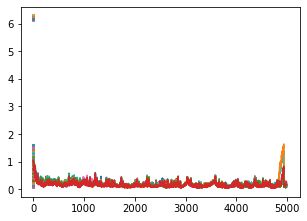

In [761]:
#plot overall atom-level results

plt.plot(rmsf_apo)
for i in range(12):
    plt.plot(rmsf_holo[i])

In [747]:
print(len(rmsf_apo))
print(len(rmsf_holo[5]))

12
4988


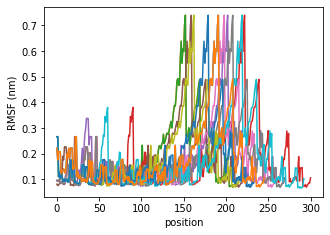

In [849]:
#plot atom-level results for ligand-lining residues
for i in range(12):
    plt.plot(rmsf_apo_ligand[i][0])
plt.xlabel('position')
plt.ylabel('RMSF (nm)')
plt.savefig('apo-atom-rmsf_12trjs.pdf')

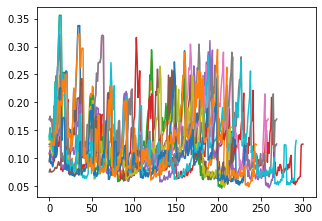

In [758]:
for i in range(12):
    plt.plot(rmsf_holo_ligand[i][0])

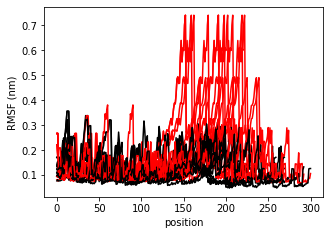

In [850]:
for i in range(12):
    plt.plot(rmsf_apo_ligand[i][0], 'r')
    plt.plot(rmsf_holo_ligand[i][0], 'k')
plt.xlabel('position')
plt.ylabel('RMSF (nm)')
plt.savefig('apo-vs.holo-atom-rmsf_12trjs.pdf')

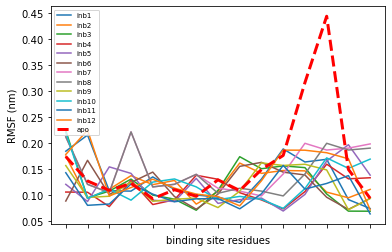

<Figure size 360x252 with 0 Axes>

In [461]:
#plot residue-level results for ligand-lining residues
fig, ax = plt.subplots()
for i in range(12):
    plt.rcParams["figure.figsize"] = (5,3.5)
    plt.plot(rmsf_holo_ligand_byres[i])
plt.plot(rmsf_apo_ligand_byres, 'r--', linewidth = 3)
plt.legend(["inb1", "inb2", "inb3", "inb4", "inb5", "inb6", "inb7", "inb8", "inb9", "inb10", "inb11", "inb12", "apo"], prop={'size': 7}, loc = 2)
plt.xticks(range(15),[])

plt.xlabel("binding site residues")
plt.ylabel("RMSF (nm)")
plt.show()
plt.savefig("binding site resi.pdf")

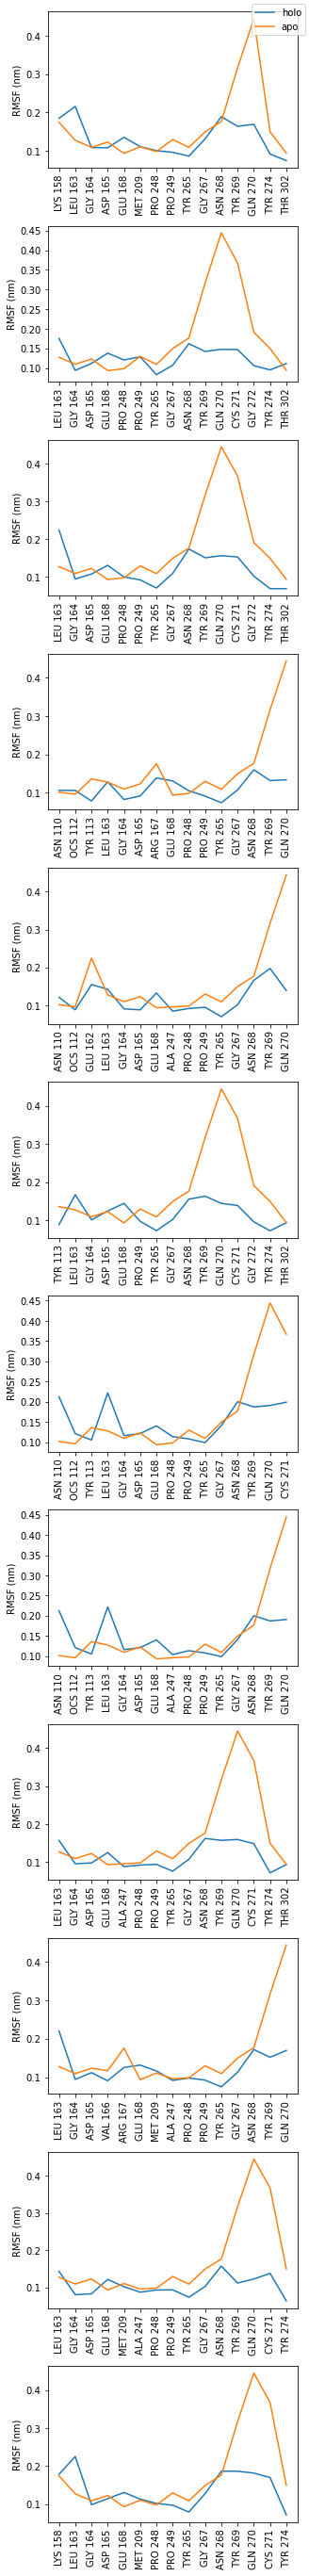

<Figure size 360x252 with 0 Axes>

In [854]:
fig, axs = plt.subplots(12, figsize = (4.5,38))
for i in range(12):
    axs[i].plot(rmsf_holo_ligand_byres[i])
    axs[i].plot(rmsf_apo_ligand_byres[i])
    lining_inds_reformat = [j[0:3]+" "+j[3:] for j in pocket_resi_matrix[i]]
    axs[i].set_xticks(range(len(rmsf_apo_ligand_byres[0])), lining_inds_reformat, size='medium', rotation = 90)
    axs[i].set_ylabel('RMSF (nm)')
fig.legend(["holo", "apo"])
fig.tight_layout()
plt.show()

plt.savefig("12_trjs_apo_vs._holo_ligand_lining_resi_RMSF.pdf")

In [306]:
f_oneway(rmsf_holo_ligand_byres[0],rmsf_holo_ligand_byres[1], rmsf_holo_ligand_byres[2], rmsf_holo_ligand_byres[3], rmsf_holo_ligand_byres[4], rmsf_holo_ligand_byres[5], rmsf_holo_ligand_byres[6], rmsf_holo_ligand_byres[7], rmsf_holo_ligand_byres[8], rmsf_holo_ligand_byres[9], rmsf_holo_ligand_byres[10],rmsf_holo_ligand_byres[11])

F_onewayResult(statistic=2.0682872449576135, pvalue=0.025168619065002198)

In [610]:
pocket_resi = []
for i in range(12):
    for j in range(15):
        pocket_resi.append(lining_inds_list[i][5][j])
pocket_resi_matrix = np.reshape(pocket_resi, (12, 15))

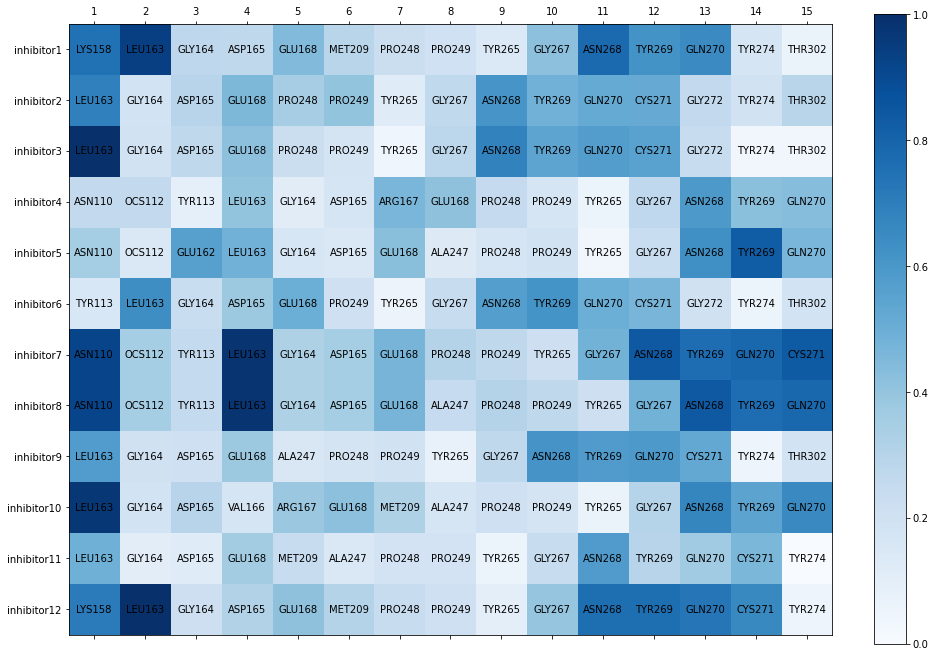

In [842]:
#plot rmsf matrix
fig, axs = plt.subplots(figsize=(15,15))

min_holo = np.amin(rmsf_holo_ligand_byres)
max_holo = np.amax(rmsf_holo_ligand_byres)
mat = axs.matshow((rmsf_holo_ligand_byres - min_holo) / (max_holo - min_holo), interpolation ='nearest', cmap=plt.cm.Blues)

resi = [i for i in range(1, 16)]
inhib = ["inhibitor" + str(i) for i in range(1, 13)] 
plt.xticks(range(15), resi)
plt.yticks(range(12), inhib)
im_ratio = rmsf_holo_ligand_byres.shape[0] / rmsf_holo_ligand_byres.shape[1]
fig.colorbar(mat, fraction = 0.047 * im_ratio)
for i in range(15):
    for j in range(12):
        axs.text(i, j, pocket_resi_matrix[j][i][:], va='center', ha='center')

plt.savefig("rmsf_holo.pdf")

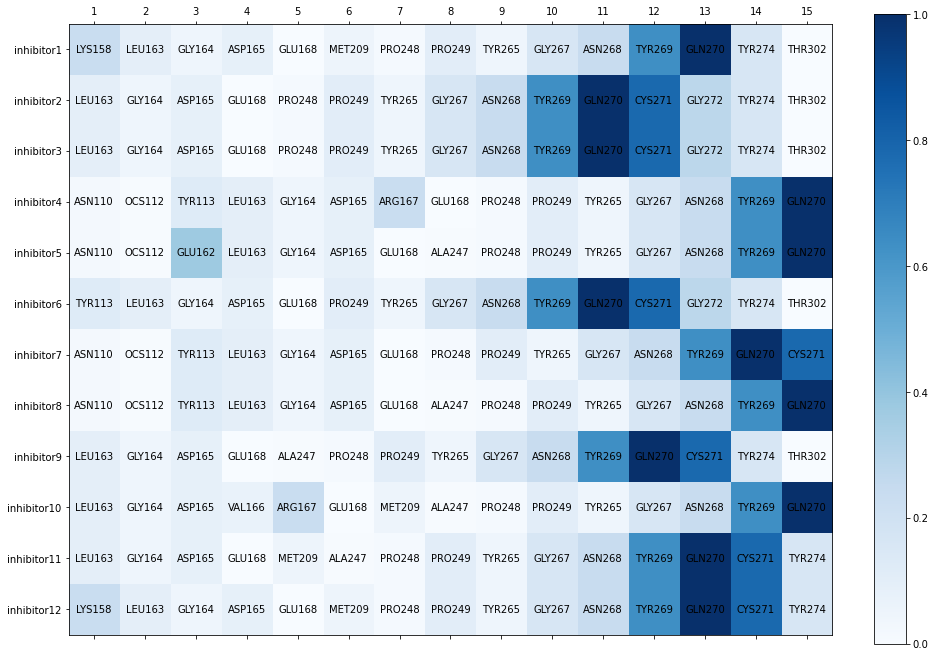

In [841]:
#plot rmsf apo matrix
fig, axs = plt.subplots(figsize=(15,15))

min_apo = np.amin(rmsf_apo_ligand_byres)
max_apo = np.amax(rmsf_apo_ligand_byres)
mat2 = axs.matshow((rmsf_apo_ligand_byres - min_apo) / (max_apo - min_apo), interpolation ='nearest', cmap=plt.cm.Blues)

resi = [i for i in range(1, 16)]
inhib = ["inhibitor" + str(i) for i in range(1, 13)] 
plt.xticks(range(15), resi)
plt.yticks(range(12), inhib)
im_ratio = rmsf_apo_ligand_byres.shape[0] / rmsf_apo_ligand_byres.shape[1]
fig.colorbar(mat2, fraction = 0.047 * im_ratio)
for i in range(15):
    for j in range(12):
        axs.text(i, j, pocket_resi_matrix[j][i][:], va='center', ha='center')

plt.savefig("rmsf_apo.pdf")

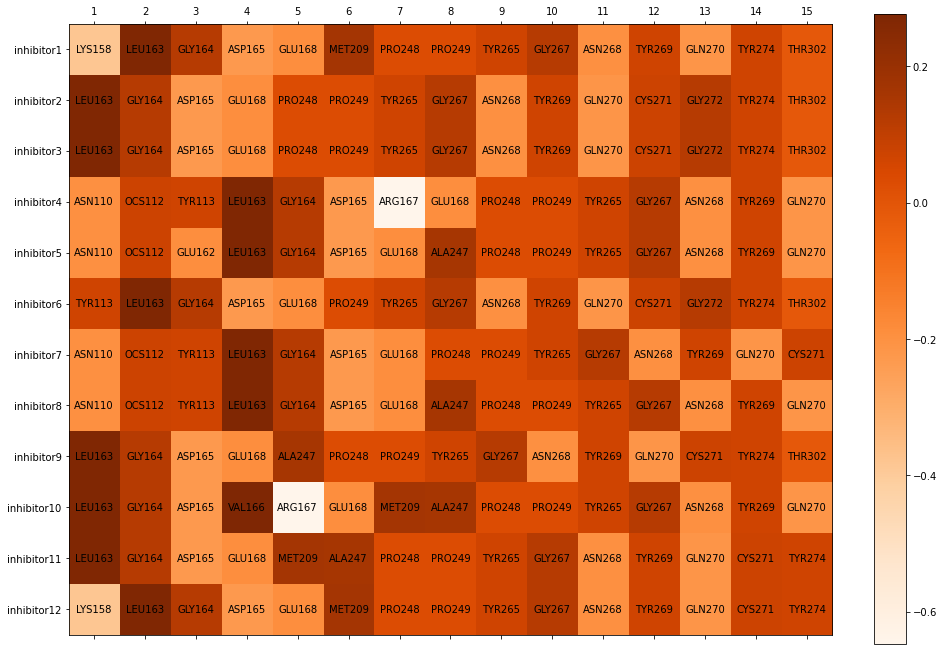

In [851]:
# get hydrophobicity matrix
hydroDict = { 
 'ALA':  0.620, 
 'ARG': -2.530,
 'ASN': -0.780,
 'ASP': -0.900,
 'CYS':  0.290,
 'GLN': -0.850,
 'GLU': -0.740,
 'GLY':  0.480,
 'HIS': -0.400,
 'ILE':  1.380,
 'LEU':  1.060,
 'LYS': -1.500,
 'MET':  0.640,
 'PHE':  1.190,
 'PRO':  0.120,
 'SER': -0.180,
 'THR': -0.050,
 'TRP':  0.810,
 'TYR':  0.260,
 'VAL':  1.080,
 'OCS':  0.290
}
hydromin = min([i for i in hydroDict.values()])
hydromax = max([i for i in hydroDict.values()])
hydroDict.update((x, (y)/ (hydromax - hydromin)) for x, y in hydroDict.items())

aa = []
for i in range(12):
    for j in range(15):
        aa.append(pocket_resi_matrix[i][j][:3])

for i in range(12):
    for j in range(15):
        hydromatrix = np.array([hydroDict[m] for m in aa])
hydromatrix = np.reshape(hydromatrix, (12, 15))

fig, axs = plt.subplots(figsize=(15,15))

mat2 = axs.matshow(hydromatrix, interpolation ='nearest', cmap=plt.cm.Oranges)

resi = [i for i in range(1, 16)]
inhib = ["inhibitor" + str(i) for i in range(1, 13)] 
plt.xticks(range(15), resi)
plt.yticks(range(12), inhib)
im_ratio = hydromatrix.shape[0] / hydromatrix.shape[1]
fig.colorbar(mat2, fraction = 0.047 * im_ratio)
for i in range(15):
    for j in range(12):
        axs.text(i, j, pocket_resi_matrix[j][i][:], va='center', ha='center')

plt.savefig("hydrophobicity.pdf")